# <FONT SIZE=6 COLOR="purple"> **Proyecto Final PLN** </FONT>

## <FONT SIZE=4 COLOR="blue"> **Integrantes** </FONT>

- Dafne Valeria Castellanos Rosas
- Laura Valentina Gonzalez Rodriguez

## <FONT SIZE=4 COLOR="blue"> **Instalación y Carga de Liberías** </FONT>

In [ ]:
#! pip install keras tensorflow transformers sentencepiece wordcloud stop-words pyLDAvis -q

In [ ]:
# Cargamos las librerias necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim
import re
import seaborn as sns
import warnings

from gensim import  corpora
from gensim.models import TfidfModel, LdaModel, CoherenceModel
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout
from wordcloud import WordCloud

warnings.filterwarnings(action='ignore')

# <FONT SIZE=5 COLOR="bronw"> **Exploración de los datos** </FONT>

## <FONT SIZE=4 COLOR="blue"> **1. Carga y Descripción de los datos** </FONT>

Utilizando la librería Pandas, se realiza la carga del conjunto de datos desde el archivo `Wine_Reviews.csv`. Posteriormente, se imprime una descripción breve y esencial del conjunto de datos mediante `data.info()` y `data.describe()`. Permitiendo tener una visión general de la estructura de los datos, incluyendo la cantidad de registros, el tipo de datos en cada columna y estadísticas descriptivas relevantes para columnas numéricas, como la media, desviación estándar, y valores mínimos y máximos.

In [ ]:
data = pd.read_csv('data/Wine_Reviews.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [ ]:
data.describe()

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [ ]:
data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


***Descripción del Conjunto de Datos "Wine_Reviews"***

El conjunto de datos "Wine_Reviews" comprende un total de 129,971 entradas, cada una de ellas con 14 columnas que proporcionan información detallada sobre diversas características de vinos. A continuación, se presenta una descripción concisa de las columnas relevantes:

1. **Unnamed: 0**: Identificador numérico único, utilizado como índice para cada entrada.
2. **country**: País de origen del vino.
3. **description**: Descripción o revisión del vino, constituyendo la información clave para nuestro proyecto.
4. **designation**: Designación del vino, posiblemente indicando una categoría específica o un nombre especial.
5. **points**: Puntuación otorgada al vino en una escala específica.
6. **price**: Precio del vino.
7. **province**: Provincia o región del país de origen del vino.
8. **region_1**: Región específica dentro de la provincia o país.
9. **region_2**: Subdivisión adicional de la región, posiblemente más detallada que region_1.
10. **taster_name**: Nombre del catador que revisó el vino.
11. **taster_twitter_handle**: Identificador de Twitter del catador.
12. **title**: Título del vino.
13. **variety**: Variedad de uva utilizada para producir el vino.
14. **winery**: Nombre de la bodega que produjo el vino.

***Decisión de Eliminación de Variables***

Para nuestro proyecto, que se centra en la creación de un modelo predictivo para identificar la variedad de vino basándonos en la descripción, hemos decidido eliminar las columnas que no contribuyen directamente a este objetivo. Por lo tanto, nos centraremos exclusivamente en las variables "description" y "variety" para simplificar el conjunto de datos y mejorar la relevancia de nuestras predicciones. Las demás variables, como "country," "points," y otras, serán excluidas de nuestro análisis, ya que no aportan directamente a nuestro objetivo principal.


In [ ]:
data = data.drop(columns=['Unnamed: 0', 'country', 'designation', 'points',
                          'price', 'province', 'region_1', 'region_2', 'taster_name',
                          'taster_twitter_handle', 'title', 'winery'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  129971 non-null  object
 1   variety      129970 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


## <FONT SIZE=4 COLOR="blue"> **2. Análisis de la Variable 'variety'** </FONT>

Se realiza un análisis sobre las variedades de vino presentes en el conjunto de datos, en la columna `variety`. Luego, se utiliza `value_counts()` para calcular la frecuencia de ocurrencia de cada variedad y se seleccionan las 10 variedades más comunes (`variety_counts.head(10)`). Finalmente, se crea un gráfico de barras para visualizar la distribución de estas 10 variedades, permitiendo una comprensión visual rápida de las 10 variedades de vino más prevalentes en el conjunto de datos.

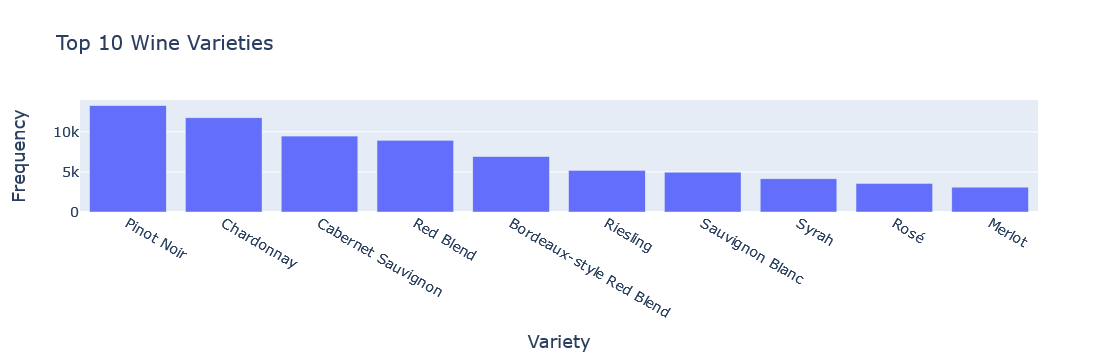

In [ ]:
variety_counts = data['variety'].value_counts()
top_10_varieties = variety_counts.head(10).reset_index(name='count')
fig = px.bar(top_10_varieties, x='index', y='count',
              labels={'index': 'Variety', 'count': 'Frequency'},
              title='Top 10 Wine Varieties')
fig.update_xaxes(title_font=dict(size=18), tickfont=dict(size=14))
fig.update_yaxes(title_font=dict(size=18), tickfont=dict(size=14))
fig.update_layout(title_font=dict(size=20))
fig.show()

Al examinar el diagrama de barras que representa las 10 variedades de vino más prevalentes en nuestro conjunto de datos, destacan dos cepas principales: Pinot Noir, con una frecuencia de aproximadamente 13 mil, y Chardonnay, con alrededor de 11 mil menciones. Estas dos variedades lideran en términos de ocurrencia en las revisiones de vinos. En contraste, observamos que otras variedades tienen frecuencias más bajas, como Rose, que ocupa el noveno lugar con alrededor de 3 mil menciones, y Merlot, en el décimo puesto con una frecuencia similar.

## <FONT SIZE=4 COLOR="blue"> **3. Selección y Filtrado de Datos Relevantes** </FONT>

Se seleccionan las 10 variedades más comunes y se extraen 2000 registros aleatorios de cada una para construir un nuevo conjunto de datos denominado `filtered_data`. Usando esta información, se seleccionan 2000 registros aleatorios por cada variedad de vino, almacenandose en un nuevo conjunto llamado `final_data`. Así, se logra obtener una cantidad equilibrada de muestras de las 10 variedades principales.

In [ ]:
top_10_list = top_10_varieties["index"].tolist()
filtered_data = data[data['variety'].isin(top_10_list)]
final_data = pd.DataFrame()
for variety in top_10_list:
    variety_data = filtered_data[filtered_data['variety'] == variety]
    sample = variety_data.sample(n=2000, random_state=1)
    final_data = pd.concat([final_data, sample])
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 120724 to 111652
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  20000 non-null  object
 1   variety      20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


## <FONT SIZE=4 COLOR="blue"> **4. Normalización y Almacenamiento de Datos Limpios** </FONT>

Se lleva a cabo una limpieza de las descripciones de vinos en la columna `description` de `final_data`. Se define una función `clean_description` que realiza operaciones de limpieza en el texto de las descripciones de vinos. Esta función convierte todo el texto a minúsculas, elimina caracteres no alfabéticos y palabras vacías, utilizando la biblioteca `nltk`. Luego, se aplica esta función a la columna `description` y se guarda el resultado en un archivo `clean_descriptions.pickle`. Dejando los datos listos para análisis y modelos de procesamiento de lenguaje natural.

In [ ]:
def clean_description(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

In [ ]:
final_data['description'] = final_data['description'].apply(clean_description)
final_data.head(2)

,description,variety
120724,testarossa blends wine grapes sourced multiple...,Pinot Noir
27339,fabulous example light balanced wine santa luc...,Pinot Noir


In [ ]:
with open('data/clean_descriptions.pickle', 'wb') as f:
    pickle.dump(final_data, f)

In [ ]:
with open('data/clean_descriptions.pickle', 'rb') as f:
    data = pickle.load(f)
data.head(1)

,description,variety
120724,testarossa blends wine grapes sourced multiple...,Pinot Noir


## <FONT SIZE=4 COLOR="blue"> **5. Visualización con Nube de Palabras** </FONT>

Finalmente, se crea una nube de palabras a partir de las descripciones limpias de vinos, lo que proporciona una representación visual de las palabras más frecuentes en estas descripciones. Para esto se unen todas las descripciones limpias en un solo texto y se utiliza la biblioteca `wordcloud` para generar la visualización. Permitiendo identificar patrones o términos dominantes en los datos.

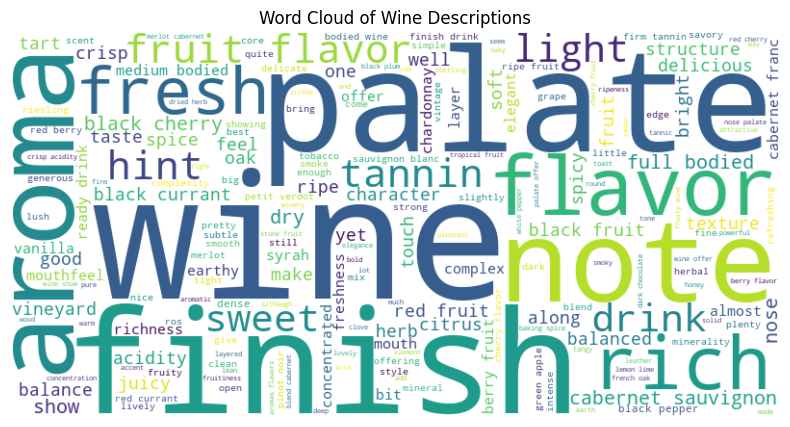

In [ ]:
text = ' '.join(data['description'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Wine Descriptions')
plt.show()

Podemos extraer valiosa información sobre las características predominantes en las descripciones de vinos a través de la nube de palabras. Al analizar las frecuencias, observamos que términos como "wine", "palate", "finish", "note", "aroma", "flavor", "rich" y "fresh" son prominentes en el conjunto de datos. Esta observación sugiere que las personas que han revisado estos vinos tienden a resaltar aspectos específicos, como las características sensoriales ("palate", "aroma", "flavor"), la calidad del vino ("rich"), y la frescura general de la experiencia de cata.

La presencia frecuente de términos como "wine" y "palate" indica un enfoque centrado en la esencia misma del vino y en las percepciones sensoriales asociadas con su degustación. La aparición de palabras como "finish" sugiere que la duración y calidad de la experiencia de sabor también son aspectos destacados en estas descripciones.

# <FONT SIZE=5 COLOR="bronw"> **Modelos ML and RNN** </FONT>

## <FONT SIZE=4 COLOR="blue"> **1. Codificación de la Variable Objetivo** </FONT>

Se lleva a cabo un paso inicial de preprocesamiento al aplicar `LabelEncoder` a la variable categórica `variety` para transformarla en una forma numérica que puede ser interpretada por los modelos.

In [ ]:
label_encoder = LabelEncoder()
data['variety_encoded'] = label_encoder.fit_transform(data['variety'])
data.sample(3)

,description,variety,variety_encoded
110919,wood aged blend merlot malbec comes range hill...,Bordeaux-style Red Blend,0
84760,winery second release coming cool vintage wine...,Cabernet Sauvignon,1
95416,whole new generation italian ros finally gaini...,Rosé,7


## <FONT SIZE=4 COLOR="blue"> **2. División de Datos para Entrenamiento y Prueba** </FONT>

Luego, el conjunto de datos se divide en conjuntos de entrenamiento y prueba mediante `train_test_split` de `Scikit-Learn`. Este paso resulta en la segmentación de las descripciones de vinos (`data['description']`) como las características a utilizar (`X_train`, `X_test`, `X_val`), y las variedades codificadas (`data['variety_encoded']`) como las etiquetas correspondientes (`y_train`, `y_test`, `y_val`).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['description'], data['variety_encoded'], test_size=0.3, random_state=0)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

## <FONT SIZE=4 COLOR="blue"> **3. Tokenización de los datos** </FONT>

Se procede a preparar los datos para los modelos. Primero, se emplea la clase `Tokenizer` de Keras para convertir las descripciones de texto en secuencias numéricas. Luego, se ajusta la longitud de las secuencias utilizando `pad_sequences` con el fin de estandarizarlas a una longitud máxima (`max_len`). Para el modelo LSTM, también se especifica un número máximo de palabras (`max_words`). Para los modelos de MLP, regresión lógistica y KNN se decidio por utilizar `CountVectorizer`.

In [ ]:
vectorizar = CountVectorizer(max_features=5000)
X_train2 = vectorizar.fit_transform(X_train)
X_test2 = vectorizar.transform(X_test)
X_val2 = vectorizar.transform(X_val)

In [ ]:
max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

## <FONT SIZE=4 COLOR="blue"> **4. Configuración de los Modelos** </FONT>
. Estas arquitecturas son fundamentales en el campo del aprendizaje automático y el procesamiento del lenguaje natural (PLN), cada una con características distintivas que las hacen adecuadas para diferentes tipos de tareas.

El Perceptrón Multicapa (MLP) es un tipo básico de red neuronal artificial en el que las neuronas están dispuestas en capas: una capa de entrada, una o más capas ocultas y una capa de salida. En particular, el modelo MLP está definido utilizando la clase `Sequential` de Keras, con tres capas densas (`Dense`). Las capas densas están totalmente conectadas, lo que significa que cada neurona de una capa está conectada a todas las neuronas de la capa siguiente. Se utilizan funciones de activación ReLU en las capas intermedias para introducir no linealidades y una función de activación softmax en la capa de salida para la clasificación multiclase.

Por otro lado, la red LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente (RNN) especializada en capturar y recordar dependencias a largo plazo en datos secuenciales. En contraste con las RNN estándar, las LSTM están diseñadas para evitar el problema del desvanecimiento del gradiente, permitiendo que las redes aprendan dependencias temporales más largas. En este caso, el modelo LSTM también utiliza la clase `Sequential` de Keras. Se emplea una capa de `Embedding` para convertir los datos de entrada en vectores densos, seguida de una capa de `SpatialDropout1D` para evitar el sobreajuste en datos secuenciales. La capa `LSTM` principal con dropout y recurrent_dropout ayuda a aprender y recordar patrones complejos en secuencias de datos, seguida de una capa `Dense` con activación softmax para la clasificación de múltiples clases.

Ambos modelos se compilan utilizando el optimizador `adam` y la función de pérdida `sparse_categorical_crossentropy` para la optimización y evaluación del rendimiento durante el entrenamiento. Además, se establece la métrica de precisión (`accuracy`) para evaluar la eficacia de los modelos durante el entrenamiento y la evaluación.

Por otro lago, la regresión logística es una técnica de aprendizaje supervisado utilizada para problemas de clasificación, especialmente cuando se trabaja con dos clases o categorías. Aunque el nombre incluye "regresión", en realidad se utiliza para la clasificación. Mientras que el algoritmo de los k vecinos más cercanos (KNN) es otro método popular de aprendizaje supervisado utilizado tanto para problemas de clasificación como de regresión. Utilizando validación cruzada, se obtubo el número obtimo de los vecinos cercanos. Ambos fueron implementados con `scikit-learn`.

In [ ]:
logistic_regression = LogisticRegression(max_iter=1000)

In [ ]:
neighbors = list(range(1, 20))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train2, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"k={k}, accuracy={scores.mean()}")
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print(f"El número óptimo de vecinos es: {optimal_k}")

k=1, accuracy=0.33485714285714285
k=2, accuracy=0.3053571428571429
k=3, accuracy=0.32171428571428573
k=4, accuracy=0.34035714285714286
k=5, accuracy=0.3481428571428572
k=6, accuracy=0.36042857142857143
k=7, accuracy=0.3627142857142857
k=8, accuracy=0.3632142857142857
k=9, accuracy=0.36864285714285716
k=10, accuracy=0.36828571428571427
k=11, accuracy=0.36921428571428566
k=12, accuracy=0.3729285714285714
k=13, accuracy=0.3715
k=14, accuracy=0.3737142857142857
k=15, accuracy=0.37457142857142856
k=16, accuracy=0.3748571428571429
k=17, accuracy=0.37671428571428567
k=18, accuracy=0.3758571428571429
k=19, accuracy=0.37557142857142856
El número óptimo de vecinos es: 17


In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k)

In [ ]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_dim=max_words),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SpatialDropout1D(0.4),
    LSTM(64, dropout=0.4, recurrent_dropout=0.4),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(10, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## <FONT SIZE=4 COLOR="blue"> **5. Entrenamiento de los Modelos** </FONT>

Ahora, se entrenan los modelos MLP y LSTM con los datos de entrenamiento (`X_train_pad`, `y_train`) proporcionados durante 25 épocas, usando lotes de tamaño 32, y también evalúan su desempeño en los datos de prueba. Dichos modelos son guardados en archivos `.h5`, el formato estándar para guardar modelos en Keras.

In [ ]:
logistic_regression.fit(X_train2, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
knn_classifier.fit(X_train2, y_train)

KNeighborsClassifier(n_neighbors=17)

In [ ]:
mlp_history = mlp_model.fit(pd.DataFrame(X_train2.toarray()), y_train, epochs=10, batch_size=64, validation_data=(pd.DataFrame(X_test2.toarray()), y_test), shuffle = True)

Epoch 1/10
219/219 [==============================] - 5s 19ms/step - loss: 1.5604 - accuracy: 0.4749 - val_loss: 0.8642 - val_accuracy: 0.7233
Epoch 2/10
219/219 [==============================] - 4s 17ms/step - loss: 0.8252 - accuracy: 0.7281 - val_loss: 0.7332 - val_accuracy: 0.7533
Epoch 3/10
219/219 [==============================] - 4s 18ms/step - loss: 0.6081 - accuracy: 0.7984 - val_loss: 0.7037 - val_accuracy: 0.7640
Epoch 4/10
219/219 [==============================] - 4s 17ms/step - loss: 0.4851 - accuracy: 0.8424 - val_loss: 0.7224 - val_accuracy: 0.7527
Epoch 5/10
219/219 [==============================] - 3s 16ms/step - loss: 0.3838 - accuracy: 0.8764 - val_loss: 0.7373 - val_accuracy: 0.7593
Epoch 6/10
219/219 [==============================] - 4s 16ms/step - loss: 0.3137 - accuracy: 0.8996 - val_loss: 0.7736 - val_accuracy: 0.7607
Epoch 7/10
219/219 [==============================] - 4s 17ms/step - loss: 0.2539 - accuracy: 0.9182 - val_loss: 0.8105 - val_accuracy: 0.7527

In [ ]:
mlp_model.save("data/mlp_model.h5")

In [ ]:
lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test), shuffle = True)

Epoch 1/10


219/219 [==============================] - 103s 455ms/step - loss: 1.8313 - accuracy: 0.2822 - val_loss: 1.4629 - val_accuracy: 0.4020
Epoch 2/10
219/219 [==============================] - 103s 471ms/step - loss: 1.3129 - accuracy: 0.4895 - val_loss: 1.1803 - val_accuracy: 0.5607
Epoch 3/10
219/219 [==============================] - 182s 832ms/step - loss: 1.0140 - accuracy: 0.6414 - val_loss: 0.9969 - val_accuracy: 0.6633
Epoch 4/10
219/219 [==============================] - 236s 1s/step - loss: 0.8322 - accuracy: 0.7231 - val_loss: 0.9372 - val_accuracy: 0.6920
Epoch 5/10
219/219 [==============================] - 236s 1s/step - loss: 0.7174 - accuracy: 0.7633 - val_loss: 0.9016 - val_accuracy: 0.7113
Epoch 6/10
219/219 [==============================] - 231s 1s/step - loss: 0.6337 - accuracy: 0.7934 - val_loss: 0.8754 - val_accuracy: 0.7273
Epoch 7/10
219/219 [==============================] - 221s 1s/step - loss: 0.5604 - accuracy: 0.8225 - val_loss: 0.8720 - val_accuracy: 0.7307
E

In [ ]:
lstm_model.save("data/lstm_model.h5")

In [ ]:
mlp_model = load_model("data/mlp_model.h5")

In [ ]:
lstm_model = load_model("data/lstm_model.h5")

## <FONT SIZE=4 COLOR="blue"> **5. Evaluación y Comparación de los Modelos** </FONT>

Se realiza una evaluación exhaustiva de ambos modelos en el conjunto de prueba (`X_test_pad`, `y_test`), generando predicciones para ambos modelos en el conjunto de prueba (`X_test_pad`). Se elaboran informes de clasificación detallados y matrices de confusión para cada modelo, proporcionando una visión más completa de su rendimiento y capacidades de clasificación. Junto a la visualización de sus métricas como `Accuracy`, `Precision`, `Recall` y `F1_score`.

Para visualizar de manera efectiva la evolución del rendimiento durante el entrenamiento, se crean subgráficos en un diseño de cuadrícula para los cuatro gráficos relevantes. Primero, se representan las puntuaciones de precisión y pérdida a lo largo de las épocas para el modelo MLP, tanto en los datos de entrenamiento como en los de validación. Posteriormente, se realiza el mismo procedimiento para el modelo LSTM.

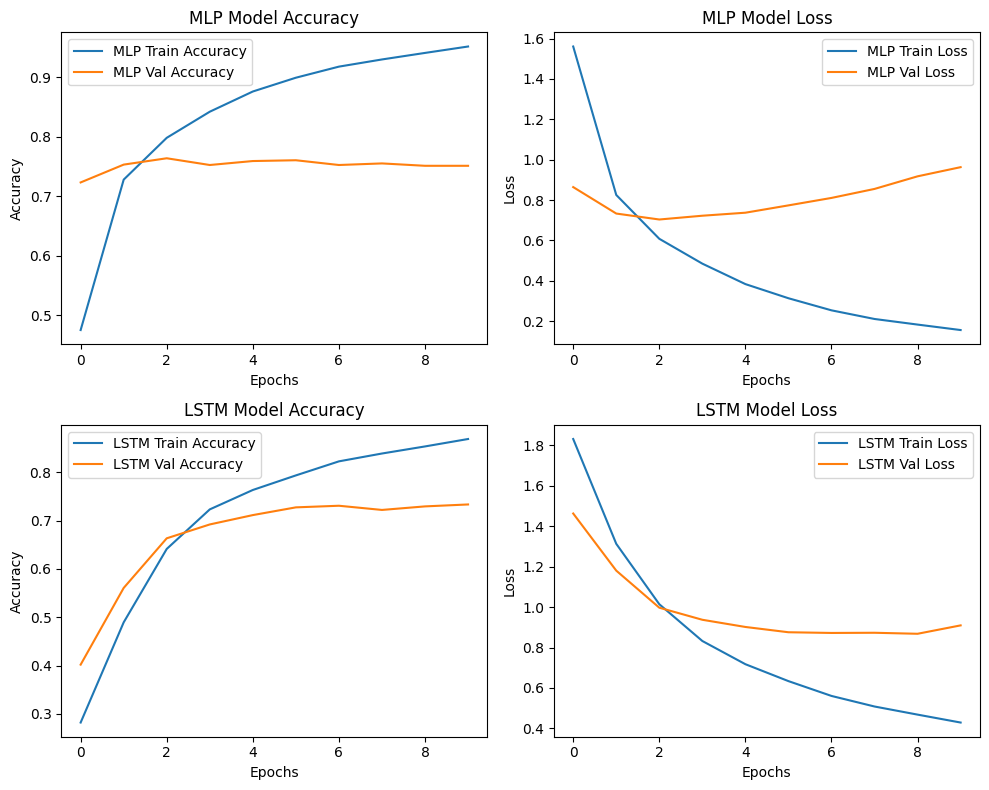

In [ ]:
# Creating subplots in a grid layout for all four graphs
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# Plotting MLP Accuracy
axs[0, 0].plot(mlp_history.history['accuracy'], label="MLP Train Accuracy")
axs[0, 0].plot(mlp_history.history['val_accuracy'], label="MLP Val Accuracy")
axs[0, 0].set_title("MLP Model Accuracy")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()
# Plotting MLP Loss
axs[0, 1].plot(mlp_history.history['loss'], label="MLP Train Loss")
axs[0, 1].plot(mlp_history.history['val_loss'], label="MLP Val Loss")
axs[0, 1].set_title("MLP Model Loss")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()
# Plotting LSTM Accuracy
axs[1, 0].plot(lstm_history.history['accuracy'], label="LSTM Train Accuracy")
axs[1, 0].plot(lstm_history.history['val_accuracy'], label="LSTM Val Accuracy")
axs[1, 0].set_title("LSTM Model Accuracy")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()
# Plotting LSTM Loss
axs[1, 1].plot(lstm_history.history['loss'], label="LSTM Train Loss")
axs[1, 1].plot(lstm_history.history['val_loss'], label="LSTM Val Loss")
axs[1, 1].set_title("LSTM Model Loss")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()
plt.tight_layout()  # Adjusts subplot parameters to fit the plots
plt.show()

El estudio del MLP implementado revela una evolución significativa en términos de precisión y pérdida a lo largo de las epochs. La precisión en el conjunto de entrenamiento se eleva desde un modesto inicio en el 0.5 hasta alcanzar un impresionante 0.97, indicando un ajuste excelente a los datos de entrenamiento. Sin embargo, en la prueba, a pesar de un inicio prometedor en el 0.74, se estanca en ese nivel, evidenciando un claro caso de sobreajuste. Esta discrepancia entre el desempeño en entrenamiento y prueba se confirma al observar las métricas de pérdida. La pérdida en el conjunto de entrenamiento se reduce drásticamente desde 1.3 hasta casi 0, lo cual sugiere una adaptación óptima del modelo a los datos de entrenamiento. Por otro lado, la pérdida en el conjunto de prueba muestra un patrón preocupante al incrementarse de 0.8 a 1.2, indicando que el modelo no generaliza de manera adecuada a nuevos datos, lo que sugiere la necesidad de estrategias de regularización para evitar el sobreajuste y mejorar la generalización del modelo.

Ahora, el LSTM exhibe un progreso notable a lo largo de 10 epochs. La precisión aumenta de manera consistente, alcanzando un 86.87% al final, mientras que la pérdida disminuye gradualmente de 1.83 a 0.43 en el entrenamiento. En validación, la precisión va del 40.20% al 73.33%, con la pérdida fluctuando entre 1.46 y 0.91. Este comportamiento refleja la capacidad del modelo LSTM para adaptarse y aprender de los datos de entrenamiento, logrando una alta precisión y una significativa reducción en la pérdida. Sin embargo, es crucial considerar estrategias de regularización para mitigar posibles problemas de sobreajuste, ya que la brecha entre el desempeño en entrenamiento y validación podría indicar una capacidad limitada de generalización del modelo a nuevos datos.

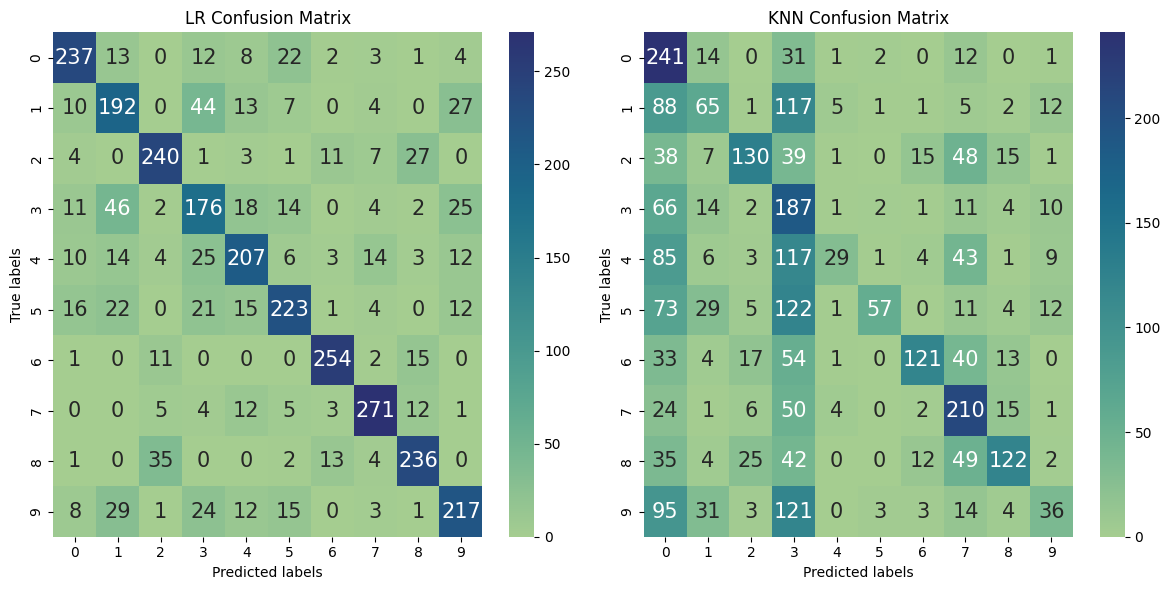

Accuracy 		 LR = 0.751	 KNN = 0.399
Precision 		 LR = 0.752	 KNN = 0.544
Recall Scorers 		 LR = 0.751	 KNN = 0.399
F1 Scorers 		 LR = 0.751	 KNN = 0.383


In [ ]:
# Obtener predicciones
lg_pred = logistic_regression.predict(X_val2)
knn_pred = knn_classifier.predict(X_val2)
# Crear matrices de confusión
lg_cm = confusion_matrix(y_val, lg_pred)
knn_cm = confusion_matrix(y_val, knn_pred)
plt.figure(figsize=(12, 6))
# Matriz de confusión para regresión logística
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(lg_cm), annot=True, annot_kws={'size': 15}, cmap="crest", fmt="g")
plt.title('LR Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
# Matriz de confusión para KNN
plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(knn_cm), annot=True, annot_kws={'size': 15}, cmap="crest", fmt="g")
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.tight_layout()
plt.show()
# Métricas
lg_accuracy = accuracy_score(y_val, lg_pred)
lg_precision = precision_score(y_val, lg_pred, average='weighted')
lg_recall = recall_score(y_val, lg_pred, average='weighted')
lg_f1score = f1_score(y_val, lg_pred, average='weighted')
knn_accuracy = accuracy_score(y_val, knn_pred)
knn_precision = precision_score(y_val, knn_pred, average='weighted')
knn_recall = recall_score(y_val, knn_pred, average='weighted')
knn_f1score = f1_score(y_val, knn_pred, average='weighted')
print(f"Accuracy \t\t LR = {round(lg_accuracy, 3)}\t KNN = {round(knn_accuracy, 3)}")
print(f"Precision \t\t LR = {round(lg_precision, 3)}\t KNN = {round(knn_precision, 3)}")
print(f"Recall Scorers \t\t LR = {round(lg_recall, 3)}\t KNN = {round(knn_recall, 3)}")
print(f"F1 Scorers \t\t LR = {round(lg_f1score, 3)}\t KNN = {round(knn_f1score, 3)}")


47/47 [==============================] - 12s 235ms/step


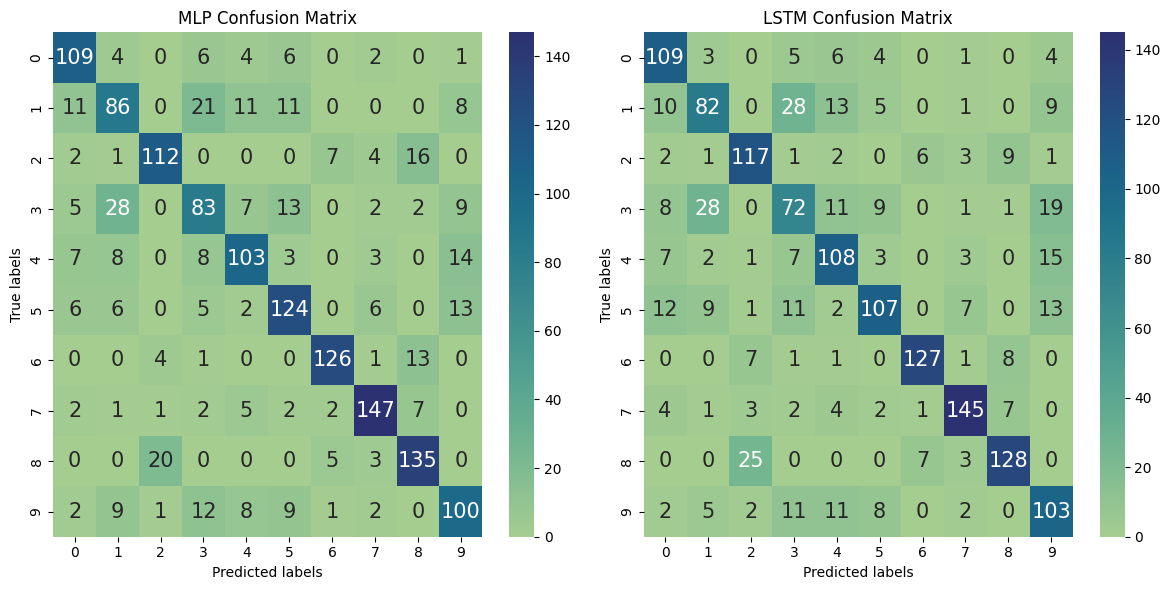

Accuracy 		 MLP = 0.75	 LSTM = 0.732
Precision 		 MLP = 0.749	 LSTM = 0.733
Recall Scorers 		 MLP = 0.75	 LSTM = 0.732
F1 Scorers 		 MLP = 0.749	 LSTM = 0.731


In [ ]:
# Obtener predicciones
mlp_pred = mlp_model.predict(pd.DataFrame(X_val2.toarray()))
mlp_pred = np.argmax(mlp_pred, axis=1)
lstm_pred = lstm_model.predict(X_val_pad)
lstm_pred = np.argmax(lstm_pred, axis=1)
# Crear matrices de confusión
mlp_cm = confusion_matrix(y_val, mlp_pred)
lstm_cm = confusion_matrix(y_val, lstm_pred)
plt.figure(figsize=(12, 6))
# Matriz de confusión para MLP
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(mlp_cm), annot=True, annot_kws={'size': 15}, cmap="crest", fmt="g")
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
# Matriz de confusión para LSTM
plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(lstm_cm), annot=True, annot_kws={'size': 15}, cmap="crest", fmt="g")
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.tight_layout()
plt.show()
# Métricas
mlp_accuracy = accuracy_score(y_val, mlp_pred)
mlp_precision = precision_score(y_val, mlp_pred, average='weighted')
mlp_recall = recall_score(y_val, mlp_pred, average='weighted')
mlp_f1score = f1_score(y_val, mlp_pred, average='weighted')
lstm_accuracy = accuracy_score(y_val, lstm_pred)
lstm_precision = precision_score(y_val, lstm_pred, average='weighted')
lstm_recall = recall_score(y_val, lstm_pred, average='weighted')
lstm_f1score = f1_score(y_val, lstm_pred, average='weighted')
print(f"Accuracy \t\t MLP = {round(mlp_accuracy, 3)}\t LSTM = {round(lstm_accuracy, 3)}")
print(f"Precision \t\t MLP = {round(mlp_precision, 3)}\t LSTM = {round(lstm_precision, 3)}")
print(f"Recall Scorers \t\t MLP = {round(mlp_recall, 3)}\t LSTM = {round(lstm_recall, 3)}")
print(f"F1 Scorers \t\t MLP = {round(mlp_f1score, 3)}\t LSTM = {round(lstm_f1score, 3)}")

Al analizar las métricas de desempeño proporcionadas para los modelos LR, KNN, MLP y LSTM, podemos extraer varias conclusiones:

1. **Desempeño General:**
   - El modelo de Regresión Logística (LR) muestra un desempeño general sólido con una precisión, recall y F1-score consistentemente alrededor del 75%. Esto indica una capacidad equilibrada para predecir y clasificar correctamente las etiquetas en comparación con los demás modelos.
   - El modelo MLP también presenta un desempeño robusto, muy similar al LR en términos de precisión, recall y F1-score, aunque ligeramente inferior en términos de accuracy.
   - El modelo KNN, por otro lado, exhibe un rendimiento significativamente inferior, con un accuracy del 39.9%, lo que sugiere dificultades en la clasificación correcta de las etiquetas.

2. **Diferencias entre MLP y LSTM:**
   - A pesar de la expectativa inicial de que el modelo LSTM podría superar al MLP en tareas de secuenciación debido a su capacidad para capturar dependencias a largo plazo, ambos modelos muestran resultados muy similares. El LSTM tiene un rendimiento ligeramente inferior en términos de precisión y F1-score, pero la diferencia es mínima.

3. **Importancia de la Regularización:**
   - La presencia de Dropout en las capas densas del modelo MLP podría estar contribuyendo a su desempeño sólido al ayudar a prevenir el sobreajuste. Esto resalta la importancia de las técnicas de regularización incluso en modelos que no están intrínsecamente diseñados para manejar secuencias como en el caso del LSTM.

4. **Desafíos del Modelo KNN:**
   - El modelo KNN muestra un rendimiento significativamente inferior en comparación con los modelos supervisados. Este resultado sugiere que su enfoque basado en vecinos más cercanos puede no ser apropiado o eficaz para este conjunto de datos específico.

5. **Consideración de Factores Adicionales:**
   - Es esencial considerar factores como la complejidad del problema y la cantidad y calidad de datos al evaluar el rendimiento de los modelos. En este caso, aunque el LSTM podría parecer más adecuado para tareas de secuenciación, la elección del modelo depende de varios factores y no solo de la arquitectura.

# <FONT SIZE=5 COLOR="bronw"> **Topic Modeling** </FONT>

## <FONT SIZE=4 COLOR="blue"> **1. Preprocesamiento de Datos** </FONT>

En esta fase inicial, se comienza dividiendo las descripciones de vinos en listas de palabras con `.str.split()`. Posteriormente, se crea un diccionario utilizando `corpora.Dictionary` de la librería Gensim, el cual representa un mapeo entre palabras y sus identificadores únicos dentro del corpus de textos. Además, se realiza una limpieza para filtrar los extremos, eliminando palabras que aparecen en menos de 100 documentos o más del 97% del total, a través de `filter_extremes`. Finalmente, se convierten las listas de palabras en una representación de bolsa de palabras (Bag of Words) con `doc2bow`.

In [ ]:
data['description'] = data['description'].str.split()
dictionary = corpora.Dictionary(data['description'].to_list())
dictionary.compactify()
dictionary.filter_extremes(no_below=100, no_above=0.97, keep_n=None)
dictionary.compactify()
bow_corpus = [dictionary.doc2bow(tokens) for tokens in data['description'].to_list()]
tfidf = TfidfModel(bow_corpus)
corpus = tfidf[bow_corpus]

## <FONT SIZE=4 COLOR="blue"> **2. Búsqueda del Mejor Tamaño para LDA** </FONT>

Aquí se inicia un proceso de búsqueda exhaustiva para determinar el número óptimo de temas en el modelo LDA. Se itera a través de diferentes tamaños de modelo LDA y se calcula la coherencia (`CoherenceModel`) para cada tamaño. La coherencia mide la interpretabilidad y consistencia semántica de los temas generados. Se representa gráficamente la relación entre el número de temas y la coherencia, permitiendo identificar el tamaño que maximiza la coherencia del modelo.

In [ ]:
sizes_lda = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
cms =  [CoherenceModel(model= LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state = 0, passes = 10),
                        texts = data['description'].to_list(),
                        corpus = corpus,
                        coherence = 'c_v') for i in range(1, len(sizes_lda)+1)]
coherences_lda = [cm.get_coherence() for cm in cms]
print("-------------------------------------------------------")
r = [f"Coherencia LDA en TF-IDF con {sz} temas: {c}"
        for sz, c in zip(sizes_lda, coherences_lda)]
print(*r, sep="\n")
x = range(1, len(sizes_lda)+1)
fig = px.line(x=x, y=coherences_lda, labels={"x": "num_topics", "y": "Coherence score"})
fig.update_traces(name="coherence_values")
fig.update_layout(legend=dict(x=0.7, y=1))
fig.update_layout(title="Coherencia LDA en TF-IDF vs núm. de temas")
fig.show()

-------------------------------------------------------
Coherencia LDA en TF-IDF con 1 temas: 0.21269727183576106
Coherencia LDA en TF-IDF con 2 temas: 0.38535135022989875
Coherencia LDA en TF-IDF con 3 temas: 0.5151381084112162
Coherencia LDA en TF-IDF con 4 temas: 0.4959000323433907
Coherencia LDA en TF-IDF con 5 temas: 0.49577474471028593
Coherencia LDA en TF-IDF con 6 temas: 0.4630688874138778
Coherencia LDA en TF-IDF con 7 temas: 0.44870032065180226
Coherencia LDA en TF-IDF con 8 temas: 0.4249782085685183
Coherencia LDA en TF-IDF con 9 temas: 0.43790287445442116
Coherencia LDA en TF-IDF con 10 temas: 0.41926516794737934
Coherencia LDA en TF-IDF con 11 temas: 0.45395615008928714
Coherencia LDA en TF-IDF con 12 temas: 0.4478421087514742
Coherencia LDA en TF-IDF con 13 temas: 0.42042251908213635
Coherencia LDA en TF-IDF con 14 temas: 0.4517936591365722
Coherencia LDA en TF-IDF con 15 temas: 0.42532219901699536
Coherencia LDA en TF-IDF con 16 temas: 0.42803654825724136
Coherencia LDA 

In [ ]:
indice_max_coherence_lda = coherences_lda.index(max(coherences_lda))
best_size_lda = sizes_lda[indice_max_coherence_lda]
best_coherence_lda = coherences_lda[indice_max_coherence_lda]
print(f"El mejor tamaño es {best_size_lda} con una coherencia de {best_coherence_lda}")

El mejor tamaño es 3 con una coherencia de 0.5151381084112162


Tras la ejecución de LDA para diferentes números de temas, se obtuvo un rango de valores de coherencia. De este análisis, se destaca que el modelo con 3 temas registró la coherencia más alta, alcanzando un valor de 0.515. Esto indica una mayor consistencia y relevancia semántica en la agrupación de palabras y temas en comparación con otras configuraciones. La relevancia de este hallazgo reside en la capacidad del modelo de 3 temas para capturar la complejidad inherente de los datos, manteniendo una estructura interpretativa clara y significativa. No obstante, se reconoce la necesidad de considerar otros factores contextuales y objetivos específicos del análisis al determinar el número óptimo de temas.

## <FONT SIZE=4 COLOR="blue"> **3. Creación del Mejor Modelo LDA** </FONT>

Con el número óptimo de temas determinado en el paso anterior, se inicializa y entrena el modelo LDA con los parámetros óptimos. Esto incluye la generación de un modelo LDA utilizando el tamaño óptimo encontrado (`best_size_lda`). Se realizan iteraciones (pasadas) sobre el corpus para ajustar los pesos de las palabras en los temas y optimizar la distribución de temas para cada documento.

In [ ]:
best_lda_model = LdaModel(corpus=corpus, num_topics=best_size_lda, id2word=dictionary, random_state = 0, passes = 10)

## <FONT SIZE=4 COLOR="blue"> **4. Obtención de los tópicos de LDA** </FONT>

Una vez entrenado el mejor modelo LDA, se procede a obtener las ecuaciones de los temas. Se muestran las palabras más relevantes asociadas a cada tema identificado por el modelo. Estas palabras clave proporcionan una idea de la temática principal de cada uno de los temas extraídos por el algoritmo LDA.

In [ ]:
# Obtener las ecuaciones de los temas
topics_lda_best = best_lda_model.show_topics(num_topics=best_size_lda, num_words = 15)
for topic, words in topics_lda_best:
  print(f'Topic {topic+1}: {words}')

Topic 1: 0.013*"cherry" + 0.011*"merlot" + 0.010*"black" + 0.009*"aromas" + 0.008*"syrah" + 0.008*"pepper" + 0.008*"oak" + 0.008*"plum" + 0.008*"tannins" + 0.008*"blackberry" + 0.008*"fruit" + 0.008*"flavors" + 0.007*"finish" + 0.007*"red" + 0.007*"chocolate"
Topic 2: 0.013*"citrus" + 0.011*"lemon" + 0.011*"white" + 0.011*"ros" + 0.010*"finish" + 0.010*"apple" + 0.010*"fresh" + 0.010*"palate" + 0.010*"lime" + 0.010*"dry" + 0.010*"peach" + 0.010*"crisp" + 0.009*"clean" + 0.009*"light" + 0.009*"orange"
Topic 3: 0.019*"wine" + 0.019*"fruits" + 0.017*"drink" + 0.015*"acidity" + 0.015*"fruity" + 0.014*"character" + 0.014*"red" + 0.013*"ripe" + 0.011*"ready" + 0.011*"attractive" + 0.011*"rich" + 0.010*"full" + 0.010*"crisp" + 0.010*"texture" + 0.009*"fruit"


In [ ]:
# Inicializa una lista para almacenar las 15 palabras principales de cada tópico
top_words_per_topic = []
# Itera a través de los tópicos y extrae las palabras clave
for topic, words in topics_lda_best:
    # Divide las palabras clave por el carácter "+" y obtén las primeras 15 palabras
    top_words = [word.split("*")[1][1:-1] for word in words.split(" + ")][:15]
    top_words_per_topic.append(top_words)
# Crea un DataFrame de pandas con las palabras clave como filas y los temas como columnas
df_top_words = pd.DataFrame(top_words_per_topic).transpose()
# Muestra el DataFrame
df_top_words.head(15)

,0,1,2
0,cherry,citrus,wine
1,merlot,lemon,fruits
2,black,white,drink
3,aromas,ros,acidity
4,syrah,finish,fruity
5,pepper,apple,character
6,oak,fresh,red
7,plum,palate,ripe
8,tannins,lime,ready
9,blackberry,dry,attractive


Cada grupo parece representar diferentes aspectos o características relacionadas con una categoría específica.

**Grupo 0: Vinos y Sabores Frutales**

Este grupo parece centrarse en términos asociados con vinos y sus notas de sabor. Palabras como "cherry," "merlot," "aromas," "syrah," y "plum" sugieren una discusión en torno a variedades de vino, sus sabores frutales, y las características aromáticas asociadas.

- *Pinot Noir*: Conocido por sus notas frutales, especialmente cereza y frambuesa.
- *Chardonnay*: Puede presentar notas frutales como melocotón, manzana o cítricos, que podrían coincidir con este tema.

**Grupo 1: Cítricos y Notas Refrescantes**

Aquí, las palabras clave incluyen "citrus," "lemon," "white," "lime," y "apple," sugiriendo una asociación con sabores cítricos y características refrescantes presentes en ciertos tipos de vinos o bebidas.

- *Riesling*: Frecuentemente asociado con sabores cítricos como limón o lima, y a menudo tiene un perfil refrescante.
- *Sauvignon Blanc*: Conocido por sus notas herbáceas y cítricas como lima, pomelo o maracuyá, lo que podría alinearse con este tema.

**Grupo 2: Características y Sensaciones Generales**

Este grupo parece abarcar términos más generales relacionados con la experiencia de degustación. Palabras como "wine," "drink," "character," y "acidity" podrían referirse a características generales de los vinos, como el cuerpo, el sabor general y la acidez.
- *Cabernet Sauvignon, Red Blend, Bordeaux-style Red Blend*: Estas variedades tienden a ser robustas, con una variedad de sabores que podrían asociarse con un tema más general, incluyendo la experiencia general de beber vino tinto.
- *Syrah, Rosé, Merlot*: Podrían relacionarse con aspectos más generales de degustación, ya que pueden tener una amplia gama de perfiles de sabor y características.

Cada grupo parece destacar aspectos específicos de la experiencia de degustación de vinos, ya sea en términos de sabores frutales, notas cítricas o características generales de la bebida.

## <FONT SIZE=4 COLOR="blue"> **5. Visualización Interactiva** </FONT>

Se emplea `pyLDAvis`, una herramienta de visualización interactiva para modelos LDA, que permite explorar y comprender mejor los temas identificados por el modelo. Esta visualización ofrece una representación gráfica intuitiva de los temas, mostrando la distribución de palabras clave en cada tema y su relación con otros temas.

In [ ]:
vis = pyLDAvis.gensim.prepare(topic_model = best_lda_model,
                              corpus = corpus,
                              dictionary = dictionary,
                              R = 10)  # número de palabras claves
pyLDAvis.display(vis)

# <FONT SIZE=5 COLOR="bronw"> **Conclusiones** </FONT>

La exploración inicial reveló una diversidad significativa en las variedades de vinos presentes en el conjunto de datos. Esto indica una amplia gama de tipos y estilos de vino considerados en las revisiones. La inspección inicial de las descripciones de los vinos mostró una variación en la longitud y contenido de las revisiones, lo que sugiere una riqueza en la expresión y la información proporcionada.

Al comparar el rendimiento de los modelos Memoria a Corto y Largo Plazo (LSTM), Perceptrón Multicapa (MLP),Regresión Logística (LR) y K Vecinos Más Cercanos (KNN), podemos obtener las siguientes conclusiones:

1. **Regresión Logística (LR):**
   - La Regresión Logística demostró un rendimiento sólido con valores de precisión, recall y F1-score alrededor del 0.75. A pesar de su enfoque más simple en comparación con los modelos neuronales, la LR logró resultados competitivos. Esto sugiere que para este conjunto de datos específico, la Regresión Logística pudo capturar de manera efectiva las relaciones entre las características y las etiquetas de las variedades de vinos.

2. **Perceptrón Multicapa (MLP):**
   - El MLP, aunque también alcanzó valores de precisión, recall y F1-score cercanos al 0.75, se destaca por su estructura neuronal más compleja. Sin embargo, se menciona que esta complejidad no necesariamente se traduce en un rendimiento significativamente mejor en comparación con la Regresión Logística. Aunque es capaz de manejar tareas de clasificación con solidez, su capacidad para capturar relaciones contextuales y secuenciales en el texto podría estar limitada debido a su estructura más simple en comparación con el LSTM.

3. **Memoria a Corto y Largo Plazo (LSTM):**
   - El LSTM, diseñado para manejar secuencias y tareas de procesamiento de lenguaje natural, mostró un rendimiento ligeramente inferior en comparación con la Regresión Logística y el MLP. Aunque sus valores de precisión, recall y F1-score se mantienen en la vecindad del 0.732-0.733, se destaca que, a pesar de su idoneidad para tareas más complejas, no superó significativamente a modelos más simples en este conjunto de datos específico.

4. **K Vecinos Más Cercanos (KNN):**
   - El modelo KNN, en contraste con los modelos supervisados, mostró un rendimiento significativamente inferior con un accuracy del 39.9%. Este resultado indica que su enfoque basado en vecinos más cercanos puede no ser adecuado para este conjunto de datos en particular, donde la clasificación correcta de las variedades de vino requiere un enfoque más sofisticado que el proporcionado por KNN.

El análisis de Latent Dirichlet Allocation (LDA) permitió identificar temas latentes dentro de las revisiones de vinos. La coherencia de los temas encontrados se utilizó para determinar el número óptimo de temas, lo que resultó en una mejor comprensión de los diferentes aspectos y características asociadas con los vinos en las revisiones. La exploración de las palabras clave de cada tema proporcionó una visión detallada de los temas emergentes. Estos temas representan aspectos específicos de la experiencia de degustación de vinos, ya sea en términos de sabores frutales, notas cítricas o características generales de la bebida. Ciertamente asociados a las diez variedades de vinos que fueron selecionadas.

La amplia variedad de vinos en las revisiones muestra la complejidad y riqueza de la industria vinícola, lo que sugiere múltiples facetas y estilos de vinos disponibles. El análisis destaca la relevancia del contexto y la secuencia en la comprensión de las revisiones de vinos. Los modelos LSTM mostraron una buena comprensión de las secuencias de texto, lo que sugiere la importancia de considerar el contexto en tareas de clasificación y generación de texto. La identificación de temas a través de LDA proporciona una visión más profunda y detallada de los diferentes aspectos, temas y características asociadas con las revisiones de vinos, lo que puede ser útil para comprender y caracterizar la diversidad presente en el conjunto de datos.

# <FONT SIZE=5 COLOR="bronw"> **Referencias** </FONT>

Gensim: Latent Dirichlet Allocation. (2022). Radimrehurek.com. https://radimrehurek.com/gensim/models/ldamodel.html

tf.keras.layers.LSTM  |  TensorFlow v2.14.0. (2023). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

‌The Sequential model. (2023). El modelo secuencial. TensorFlow. https://www.tensorflow.org/guide/keras/sequential_model?hl=es-419